# Neural Network Project

## Emotion Detection through Speech

##  ECE 5268 Theory and Applications of Neural Networks

**Background**: *Sentiment analysis* is the process of analyzing digital text to determine if the emotional tone of the message is positive, negative, or neutral. More specifically, sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

Often times, it is not *what* is said, but *how* it is said. Text-based models may miss this aspect and as such, it may prove useful to also analyze digital voice signals in the same context.

To this end, audio files were analyzed to determine the *mood* of the speaker.

**Data**: Audio datasets with around 2000 audio files which were in the wav format from the following websites:

1) http://neuron.arts.ryerson.ca/ravdess/?f=3,

2) http://kahlan.eps.surrey.ac.uk/savee/Download.html 



In [1]:
#!pip install librosaimport librosa
#!pip install numba
#import librosa
import librosa.display

In [2]:
import os
import sys

import pandas as pd
import glob 
import numpy as np
import scipy.io.wavfile
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

## Data Fetching & Processing

In [11]:
#mylist= os.listdir('RawData/')
dataDir = '/Users/alesandrawiecheckivergara/Desktop/NN/EmotionalClassifier/RawData/'
mylist= os.listdir(dataDir)
len(mylist)
#print(mylist)

1441

### Apparently, there's some *hidden* file within the directory that pops up--needs to be deleted!

In [12]:
mylist.sort()
print(mylist[0])
mylist.pop(0)
print(mylist[0])
len(mylist)

.DS_Store
03-01-01-01-01-01-01.wav


1440

In [13]:
print(mylist[0]) # Waveform filename

03-01-01-01-01-01-01.wav


In [14]:
print(mylist[0][6:-16]) # Waveform label

01


In [15]:
print(dataDir+mylist[0]) # Absolute path to waveform filename

/Users/alesandrawiecheckivergara/Desktop/NN/EmotionalClassifier/RawData/03-01-01-01-01-01-01.wav


## Plotting the audio file's waveform and its spectrogram

In [16]:
testWaveformFile = dataDir + mylist[0]

In [17]:
data, sampling_rate = librosa.load(testWaveformFile)

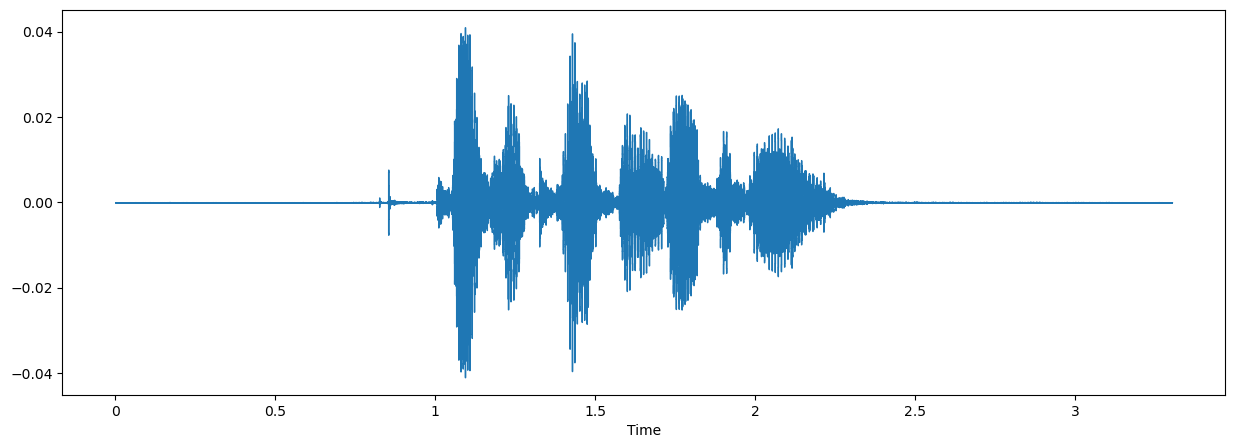

In [18]:
#%% pylab inline
plt.figure(figsize=(15, 5))
#librosa.display.waveplot(data, sr=sampling_rate)   # *** Deprecated call ***
librosa.display.waveshow(data, sr=sampling_rate)    # *** Correct method call ***

/var/folders/vm/4smn9zd95g9_bntdm1l3lp2w0000gn/T/ipykernel_12151/898486552.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read(testWaveformFile)
/var/folders/vm/4smn9zd95g9_bntdm1l3lp2w0000gn/T/ipykernel_12151/898486552.py:21: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


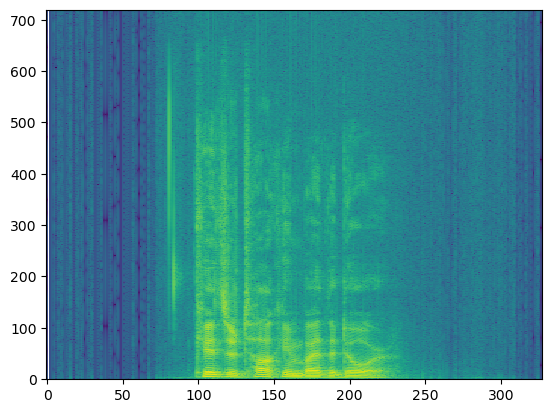

In [19]:
#sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')
sr,x = scipy.io.wavfile.read(testWaveformFile)

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Define the category labels for this project

In [20]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [21]:
labels = pd.DataFrame(feeling_list)
#print(labels.shape)
#print(labels.index)
#print(labels.info())
display(labels)

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
...,...
955,female_fearful
956,male_fearful
957,female_fearful
958,male_fearful


In [22]:
labels[:10]
print(len(labels[0].unique()))

10


## Building the *MFCC* feature `dataframe` from the audio files using librosa

In [23]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
#   if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
    fileLabel = mylist[index][6:-16]
#    if fileLabel!='01' and fileLabel!='07' and fileLabel!='08' and fileLabel!='su' and fileLabel!='n' and fileLabel!='d':
    if fileLabel not in set(["01","07","08","su","n","d"]):
        
        # *** Change 'dataDir' & 'res_type' ***
        #X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        X, sample_rate = librosa.load(dataDir+y, res_type='scipy',duration=2.5,sr=22050*2,offset=0.5)
        
        sample_rate = np.array(sample_rate)
        
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                             sr=sample_rate, 
                                             n_mfcc=13),
                                             axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1


In [24]:
print(df.shape)
df[:5]

(960, 1)


,feature
0,"[-70.269356, -70.269356, -70.269356, -70.26935..."
1,"[-65.708786, -65.708786, -63.116146, -61.52054..."
2,"[-65.48411, -65.48411, -65.48411, -65.48411, -..."
3,"[-64.529945, -64.529945, -64.529945, -64.52994..."
4,"[-63.65401, -59.980293, -61.867172, -67.4973, ..."


In [25]:
#print(len(df['feature'].values[0]))
#df['feature'].values[0]

In [26]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [27]:
type(df3)

pandas.core.frame.DataFrame

## Build out the dataset: [Data, Labels]

In [28]:
newdf = pd.concat([df3,labels], axis=1)

In [29]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [30]:
#rnewdf[:5]

In [31]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
#rnewdf[:10]

### Set all `nan`s to 0.0

In [32]:
rnewdf=rnewdf.fillna(0)

### Export dataframe (due to `tf` and `librosa` conflict)

In [33]:
rnewdf.to_pickle('feature') # Export to disk